This script will export a plot containing three subplots:
    * The original observed image
    * The reconstructed image using lenstronomy with galfir caustic and critical lines overlayed ontop

In [2]:
__author__ = 'edenm'
import pickle
from lenstronomy.Plots.output_plots import LensModelPlot
import pandas as pd
import numpy as np
import astropy.io.fits as fits
import scipy.ndimage as sim
import re
import matplotlib.pyplot as plt
plt.rcParams['ps.fonttype'] = 42
import seaborn as sns
plt.rcParams['font.family'] = 'serif'
plt.rcParams['font.serif'] = 'Times New Roman'
plt.rcParams['mathtext.rm'] = 'serif'
plt.rcParams['mathtext.it'] = 'serif:italic'
plt.rcParams['mathtext.bf'] = 'serif:bold'
plt.rcParams['mathtext.fontset'] = 'custom'
sns.set(style='ticks', context='paper', font='Times New Roman', font_scale=2.)
sns.set_style({"xtick.direction": "in", "ytick.direction": "in", "axes.linewidth": 1.0, })
from mpl_toolkits.axes_grid1 import make_axes_locatable

## Functions for Plotting the Reconstructed Images

In [6]:
# Plots the image data
def data_plot(self, ax, v_min=None, v_max=None, text='Observed', frame_size=None):
    """
    :param ax:
    :return:
    """
    im = ax.matshow(np.log10(self), origin='lower',
                    extent=[0, frame_size, 0, frame_size], cmap="gist_heat", vmin=v_min,
                    vmax=v_max)  # , vmin=0, vmax=2

    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
    ax.autoscale(False)

    scale_bar(ax, frame_size, dist=1, text='1"')
    text_description(ax, frame_size, text=text, color="w", backgroundcolor='k')

    divider = make_axes_locatable(ax)
    cax = divider.append_axes("right", size="5%", pad=0.05)
    cb = plt.colorbar(im, cax=cax, orientation='vertical')
    cb.set_label(r'log$_{10}$ flux', fontsize=15)
    return ax

In [5]:
# Creates scale bar on plot relating arcseconds to pixels
def scale_bar(ax, d, dist=1., text='1"', color='w', flipped=False):
    xlim, ylim = ax.get_xlim(), ax.get_ylim()

    print ("These are the limits of the lenstronomy plot", xlim, ylim)
    if flipped:
        p0 = d - d / 15. - dist
        p1 = d / 15.
        ax.plot([p0, p0 + dist], [p1, p1], linewidth=2, color=color)
        ax.text(p0 + dist / 2., p1 + 0.01 * d, text, fontsize=15, color=color, ha='center')
    else:
        p0 = d / 15.
        ax.plot([p0, p0 + dist], [p0, p0], linewidth=2, color=color)
        ax.text(p0 + dist / 2., p0 + 0.01 * d, text, fontsize=15, color=color, ha='center')

In [7]:
# Create a text description on the plot for 'Observed', 'Reconstruction', 'Normalized Residuals'
def text_description(ax, d, text, color='w', backgroundcolor='k', flipped=False):
    if flipped:
        ax.text(d - d / 40., d - d / 15., text, color=color, fontsize=15, backgroundcolor=backgroundcolor)
    else:
        ax.text(d / 40., d - d / 15., text, color=color, fontsize=15, backgroundcolor='k')

In [9]:
# Gets the pickled data from the LenstronomyMaster notebook
def getPickledData(Path, LensName):
    """
    Path: basepath to where the data is stored
    LensName: name of the system being worked on
    """
    pick_path = Path

    kwargs_data = pickle.load(open("%s/kwargs_data_%s.pickle" % (pick_path, LensName), 'rb'))
    kwargs_psf_out = pickle.load(open("%s/kwargs_psf_out_%s.pickle" % (pick_path, LensName), 'rb'))
    kwargs_numerics = pickle.load(open("%s/kwargs_numerics_%s.pickle" % (pick_path, LensName), 'rb'))
    kwargs_model = pickle.load(open("%s/kwargs_model_%s.pickle" % (pick_path, LensName), 'rb'))
    lens_result = pickle.load(open("%s/lens_result_%s.pickle" % (pick_path, LensName), 'rb'))
    source_result = pickle.load(open("%s/source_result_%s.pickle" % (pick_path, LensName), 'rb'))
    lens_light_result = pickle.load(open("%s/lens_light_result_%s.pickle" % (pick_path, LensName), 'rb'))
    ps_result = pickle.load(open("%s/ps_result_%s.pickle" % (pick_path, LensName), 'rb'))
    param_list = pickle.load(open("%s/param_list_%s.pickle" % (pick_path, LensName), 'rb'))
    chain_list = pickle.load(open("%s/chain_list_%s.pickle" % (pick_path, LensName), 'rb'))

    # For makillng 0.4.0 compaatible with 0.4.5; in 0.4.5 has 'ra_0': 0 and 'dec_0':0
    try:
        del lens_result[1]['ra_0']
        del lens_result[1]['dec_0']
    except:
        pass

    return lens_result, source_result, lens_light_result, ps_result, chain_list, param_list, kwargs_data, kwargs_numerics, kwargs_model, kwargs_psf_out


In [10]:
# Plotting Routine
def getPlots(Path, LensName, src_rotated0, src_rotated1, crit_rotated, crop_factor):
    """
    Path: Base path to the Data
    LensName: Name of lens currently being worked on
    src_rotated0, src_rotated1, crit_rotated: gravlens parameters
    crop_factor: how much to crop the original image
    """
    
    "Get the pickled data"
    numPix = crop_factor*2
    deltaPix = 0.009942
    frame_size = numPix*deltaPix

    lens_result, source_result, lens_light_result, ps_result, chain_list, param_list, kwargs_data, kwargs_numerics, kwargs_model, kwargs_psf_out = getPickledData(
        Path, LensName)

    "Plotting the Data"
    lensPlot = LensModelPlot(kwargs_data, kwargs_psf_out, kwargs_numerics, kwargs_model, lens_result, source_result,
                             lens_light_result, ps_result, arrow_size=0.02, cmap_string="gist_heat")

    "Testing: getting the model"
    import lenstronomy.Util.class_creator as class_creator
    import lenstronomy.Util.class_creator as class_creator
    imageModel = class_creator.create_image_model(kwargs_data, kwargs_psf_out, kwargs_numerics, kwargs_model)
    model, error_map, cov_param, param = imageModel.image_linear_solve(lens_result, source_result,
                                                                             lens_light_result, ps_result)
    print ("This is the model")
    print (np.shape(model))

    plt.close()
    f, axes = plt.subplots(1, 3, figsize=(14, 4), sharex=False, sharey=False)
    data_plot(model,ax=axes[0], frame_size=frame_size)
    #For Plotting the Reconstructed Image with Critical and Caustic Lines
    axes2 = plt.subplot(132)
    im = axes2.imshow(np.log10(model), origin='lower', cmap="gist_heat",
                      # vmin= max(np.min(np.log(model)), -5), vmax=min(np.max(np.log(model)), 10),
                      vmin = None, vmax = None,
                 extent=[-maxextent, maxextent, -maxextent, maxextent])

    axes2.plot(src_rotated0, src_rotated1, '*', color='#1f78b4', markersize=18)  # Bllue

    for i in range(len(crit_rotated)):
        axes2.plot([crit_rotated[i, 0], crit_rotated[i, 4]], [crit_rotated[i, 1], crit_rotated[i, 5]], '-',
                 color='#ffff33',
                 linewidth=1.5)  # Yellow
    for i in range(len(crit_rotated)):
        axes2.plot([crit_rotated[i, 2], crit_rotated[i, 6]], [crit_rotated[i, 3], crit_rotated[i, 7]], '--',
                 color='#e41a1c',
                 linewidth=1.5)  # Red

    #Plot a Scale Bar on the plot
    print ("Plotting Scale Bar Line 131, ", frame_size)
    xlim, ylim = axes2.get_xlim(), axes2.get_ylim()
    print ("These are the limits of the reconstucted plot", xlim, ylim)
    xstart = xlim[0] + 0.1 * (xlim[1] - xlim[0])  # This sets the start of the line 10% from left side of panel
    xend = xstart + 1  # This makes the line 1 arcsecond long
    y = ylim[0] + 0.07 * (ylim[1] - ylim[0])
    axes2.plot([xstart, xend], [y, y], linewidth=2, color='w')  # Actually draw the line
    axes2.text(xstart + .5, y - 0.02 * y, '1"', fontsize=15, color='w', ha='center')

    #Plot a textbox on the plot
    axes2.text(xlim[0]+.07 , - ylim[0]-.19, "Reconstructed", color='w', fontsize=15, backgroundcolor='k')

    #Plot the colorbar
    from mpl_toolkits.axes_grid1 import make_axes_locatable
    divider = make_axes_locatable(axes2)
    cax = divider.append_axes("right", size="5%", pad=0.05)
    cbar = plt.colorbar(im, cax = cax)
    cbar.set_label(r'log$_{10}$ flux', fontsize=15)

    # Hide the tick labels
    plt.xticks([])
    plt.yticks([])

    #lensPlot.model_plot(ax=axes[1])
    lensPlot.normalized_residual_plot(ax=axes[2], v_min=-6, v_max=6)
    f.tight_layout(pad=.25)

    # f.subplots_adjust(left=None, bottom=None, right=None, top=None, wspace=0., hspace=.05)
    plt.savefig("%s/%s_Gravlens_Reconst.pdf" % (Path, LensName))
    print ("Plotted first plot!")

## Functions for getting the `gravlens` results

In [13]:
PI = np.pi

In [15]:
def findAfter(string, substring, Nskip, delimiter):
    start_ind = string.find(substring) + len(substring) + 2
    skip_count = 0
    while skip_count < Nskip:
        start_ind = string.find(delimiter, start_ind) + 1
        skip_count += 1
    end_ind = string.find(delimiter, start_ind)
    extracted = string[start_ind:end_ind]
    return extracted

In [16]:
def getPosition(filename, pattern, pos1, pos2):
    with open(filename, 'r') as f:
        best = f.readlines()
    LensPosition = list()
    # Iterate each line
    for line in best:

        # Regex applied to each line
        match = re.search(pattern, line)
        if match:
            # Make sure to add \n to display correctly when we write it back
            # 5 and 9
            LensPosition.append(float(match.group(pos1)))
            LensPosition.append(float(match.group(pos2)))
    return LensPosition

In [17]:
def makeArray(data):
    array = np.asarray(data)
    return array

In [18]:
def rotation(x, y, angle):
    xprime = x * np.cos(angle / 180. * PI) - y * np.sin(angle / 180. * PI)
    yprime = x * np.sin(angle / 180. * PI) + y * np.cos(angle / 180. * PI)
    return xprime, yprime

## Main Plotting Routine

In [21]:
def getGalFitPlotData(Path, LensName, fitspath, basepath, foldername, crop_factor):
    hdulist = fits.open(fitspath)

    best_path = "%s/%s/fit2.dat" % (basepath, foldername)
    crit_path = "%s/%s/crit.dat" % (basepath, foldername)
    output_path = "%s/%s.pdf" % (basepath, LensName)
    data = hdulist[0].data

    try:
        PA = hdulist[0].header['PA_IMAG']
    except:
        print "Setting PA = 0"
        PA = 0

    #Pad the image with zeros to allow for PA rotation
    pad_size = 1000
    data = np.pad(data, ((pad_size, pad_size), (pad_size, pad_size)), 'constant', constant_values=0)
    with open(best_path, 'r') as f:
        best = f.read()
        f.close()

    # Galaxy and source positions
    gal = getPosition(best_path,
                      'alpha ([-+]?(\d+(\.\d*)?|\.\d+)([eE][-+]?\d+)?) ([-+]?(\d+(\.\d*)?|\.\d+)([eE][-+]?\d+)?) ([-+]?(\d+(\.\d*)?|\.\d+)([eE][-+]?\d+)?)',
                      5, 9)
    src = getPosition(best_path,
                      'ptsrc ([-+]?(\d+(\.\d*)?|\.\d+)([eE][-+]?\d+)?) ([-+]?(\d+(\.\d*)?|\.\d+)([eE][-+]?\d+)?) ([-+]?(\d+(\.\d*)?|\.\d+)([eE][-+]?\d+)?)',
                      5, 9)
    img = getPosition(best_path, '(->) ([-+]?(\d+(\.\d*)?|\.\d+)) ([-+]?(\d+(\.\d*)?|\.\d+))', 2, 5)

    # convert to arrays
    gal = makeArray(gal)
    src = makeArray(src)

    #Coordinates of images
    imgs0 = img[0], img[1]
    imgs1 = img[2], img[3]
    # imgs0 = 29.37, 34.83
    # imgs1 = 65.49, 51.34

    imgs = np.array([imgs0, imgs1])

    gal += [1000, 1000]
    src += pad_size
    imgs += pad_size

    # Get image and source positions relative to galaxy
    imgs[0] -= gal
    imgs[1] -= gal
    src -= gal

    # Critical lines and caustics: x1, y1, u1, v1, x2, y2, u2, v2
    crit = np.loadtxt(crit_path)

    crit += pad_size
    crit[:, [0, 2, 4, 6]] -= gal[0]
    crit[:, [1, 3, 5, 7]] -= gal[1]

    # Go from pixel coordinates to arcseconds
    arcsecperpixel = 0.01  # TODO: Grab this from the header
    imgs *= arcsecperpixel
    crit *= arcsecperpixel
    src *= arcsecperpixel

    # Determine how large to make the image
    extent = int(1. / arcsecperpixel)
    # maxextent = max(np.max(np.abs(imgs)), np.max(np.abs(crit)))
    "Change values here to change how much to zoom in depending on the system"
    # maxextent = 1.1 * np.ceil((1. / 0.2) * maxextent)

    maxextent = float(crop_factor)/float(extent) #Bigger multiplier = more zoomed out
    extent = float(extent) * float(maxextent)

    # Rotate by position angle
    data_rotated = sim.rotate(
        data[int(gal[1] - extent):int(gal[1] + extent), int(gal[0] - extent):int(gal[0] + extent)], -PA, reshape=False,
        order=0)

    src_rotated = [0, 0]
    src_rotated[0], src_rotated[1] = rotation(src[0], src[1], PA)
    crit_rotated = np.zeros((len(crit), 8))
    for i in range(len(crit)):
        crit_rotated[i, 0], crit_rotated[i, 1] = rotation(crit[i, 0], crit[i, 1], PA)
        crit_rotated[i, 2], crit_rotated[i, 3] = rotation(crit[i, 2], crit[i, 3], PA)
        crit_rotated[i, 4], crit_rotated[i, 5] = rotation(crit[i, 4], crit[i, 5], PA)
        crit_rotated[i, 6], crit_rotated[i, 7] = rotation(crit[i, 6], crit[i, 7], PA)

    "This will plot the original data with the gravlens outputs"
    PlottingBool = True
    if PlottingBool:

        # Plot the image with critical lines and caustics
        plt.figure(figsize=(5, 5))
        ax1 = plt.subplot(111)
        data_rotated[data_rotated < 0.] = 1e-10
        im = plt.imshow(np.log10(data_rotated),  # use log10 as the scale than let's you compare change in magnitude
                        origin='lower',
                        vmin=-.9,
                        vmax=2,
                        extent=[-maxextent, maxextent, -maxextent, maxextent],
                        cmap=sns.cubehelix_palette(start=0.5, rot=-1.5, gamma=1., hue=1.,
                                                   # l/ight=.8,
                                                   dark=0.,
                                                   reverse=True,
                                                   as_cmap=True))  # plt.axvline(x=0, linestyle='dashed', color='k')

        # plt.axhline(y=0, linestyle='dashed', color='k')
        # x is in the image plane
        ax1.plot(src_rotated[0], src_rotated[1], '*', color='#1f78b4', markersize=18)  # Bllue

        for i in range(len(crit_rotated)):
            ax1.plot([crit_rotated[i, 0], crit_rotated[i, 4]], [crit_rotated[i, 1], crit_rotated[i, 5]], '-',
                     color='#ffff33',
                     linewidth=1.5)  # Yellow
        for i in range(len(crit_rotated)):
            ax1.plot([crit_rotated[i, 2], crit_rotated[i, 6]], [crit_rotated[i, 3], crit_rotated[i, 7]], '--',
                     color='#e41a1c',
                     linewidth=1.5)  # Red

        # Hide the tick labels
        plt.xticks([])
        plt.yticks([])

        Scale_Direction_Bool = True
        if Scale_Direction_Bool:
            "Add the scale"
            xlim, ylim = ax1.get_xlim(), ax1.get_ylim()
            xstart = xlim[0] + 0.1 * (xlim[1] - xlim[0])  # This sets the start of the line 10% from left side of panel
            xend = xstart + 1  # This makes the line 1 arcsecond long
            y = ylim[0] + 0.1 * (ylim[1] - ylim[0])  # This sets the line 80% to the top of the panel
            ax1.plot([xstart, xend], [y, y], 'w-', lw=4, solid_capstyle='butt')  # Actually draw the line
            ax1.text(xstart + .5, y + .2, r'${1 \prime\prime}$', horizontalalignment='center', color='w')

            "North Direciton Arrow"
            x_arrow = xlim[0] + .9 * (xlim[1] - xlim[0])
            plt.arrow(x_arrow, y, 0, .5, head_width=.1, head_length=.08, fc='w', ec='w', width=.025)
            ax1.text(x_arrow, y + .7, 'N', horizontalalignment='center', color='w')
            plt.arrow(x_arrow, y, -.5, 0, head_width=.1, head_length=.08, fc='w', ec='w', width=.025)
            ax1.text(x_arrow - .7, y, 'E', horizontalalignment='center', color='w')

        # make colorbar same size of the plot
        from mpl_toolkits.axes_grid1 import make_axes_locatable
        divider = make_axes_locatable(ax1)
        cax = divider.append_axes("right", size="5%", pad=0.05)
        cbar = plt.colorbar(im, cax=cax)
        cbar.ax.set_ylabel(r'$\log_{10}({\rm (Flux)counts/sec})$', rotation=90)

        plt.tight_layout(pad=.5)

        plt.savefig('%s/%s_Galfit.pdf' %(Path, LensName), dpi=326)

    return maxextent, src_rotated[0], src_rotated[1], crit_rotated, crop_factor

In [22]:
# Loading the config file
config_file = pd.read_excel("/Users/edenmolina/PycharmProjects/Quasar/Lenstronomy/LenstronomyConfig.xlsx", sheetname="Master")
Names = config_file['Name']
Paths = config_file['Path']
RunBool = config_file['RunBool']
G_base_path = config_file['G_BasePath']
Folder_Name = config_file['Folder_Name']
Crop_Factor = config_file['Crop_Factor']

/anaconda3/lib/python2.7/site-packages/pandas/io/excel.py:329: FutureWarning: The `sheetname` keyword is deprecated, use `sheet_name` instead
  **kwds)


## Running the plotting routine

Skipping J0047 

Skipping J0246sel 

Skipping J0806 

Skipping J1001 

Skipping J1650 

Skipping J2209 

Skipping J1206 

Plotting JU673
Setting PA = 0


KeyboardInterrupt: 

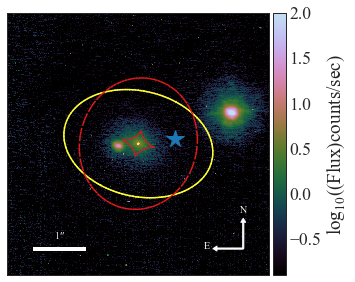

In [24]:
for i in range(len(Names)):
    if RunBool[i] == 1:
        print "Plotting %s"%Names[i]

        "This is the directory the script will output plots"
        LensTronomyOutDir = "/Users/edenmolina/PycharmProjects/Quasar/Lenstronomy"

        #Plotting Gravlens Results
        maxextent, src_rotated0, src_rotated1, crit_rotated, crop_factor = getGalFitPlotData(LensTronomyOutDir, Names[i], Paths[i], G_base_path[i], Folder_Name[i], Crop_Factor[i])

        #Plots Lenstronomy Outputs
        getPlots(LensTronomyOutDir, Names[i], src_rotated0, src_rotated1, crit_rotated, crop_factor)
    else:
        print "Skipping %s" % Names[i], "\n"
